# 🤰 Maternal Health Risk Analysis: A Comparative ML Study
> **Predicting pregnancy risk levels using IoT-based clinical vital signs.**

---

## 📝 Executive Summary
This notebook explores the application of **Machine Learning (Random Forest)** and **Deep Learning (Dense Neural Network)** to predict maternal health risks. By analyzing vital signs collected from rural healthcare centers, we aim to provide an early-warning system to improve clinical outcomes for mothers and infants.

## 🎯 Objectives
* **Model Benchmarking**: Compare traditional Supervised Learning (RF) with Deep Learning (DNN).
* **Feature Analysis**: Identify key clinical indicators (Blood Glucose, BP, etc.) for high-risk detection.
* **Clinical Utility**: Prioritize **Recall** and **Precision** to ensure patient safety and resource efficiency.

## 📊 Dataset
* **Source**: UCI Machine Learning Repository (Maternal Health Risk Data).
* **Input Features**: Age, SystolicBP, DiastolicBP, Blood Sugar (BS), Body Temp, Heart Rate.
* **Classification**: Binary (High Risk vs. Low Risk).

---
*Created by [yHow]

In [36]:
# Install required packages
%pip install joblib
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Import required libraries

In [37]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# File and metadata management
from pathlib import Path
import json

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, 
    roc_curve, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix)

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model persistence
import joblib

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [38]:
# Suppress warnings for cleaner output
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore")

## 2. Data preparation
### 2.1 Load the raw data

In [39]:
# load data
data_path = Path("data/Maternal_Health_Risk_Data_Set_Modified.csv")
data = pd.read_csv(data_path)

print("Data Shape:", data.shape)
print(f"\nFirst few rows:")
data.head()

Data Shape: (679, 8)

First few rows:


,CitizenID,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,C001,25.0,130,80,15.0,98.0,86.0,high risk
1,C002,35.0,140,90,13.0,98.0,70.0,high risk
2,C003,29.0,90,70,8.0,100.0,80.0,high risk
3,C004,30.0,140,85,7.0,98.0,70.0,high risk
4,C005,35.0,120,60,6.1,98.0,76.0,low risk


### 2.2 Initial data exploration

In [40]:
# Basic data exploration
print("\nDataset Info:")
print(data.info())
print("\n"+"="*50+"\n")

# Statistical summary
print("Statistical Summary:", data.describe(), sep="\n")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CitizenID    679 non-null    object 
 1   Age          677 non-null    float64
 2   SystolicBP   679 non-null    int64  
 3   DiastolicBP  679 non-null    int64  
 4   BS           679 non-null    float64
 5   BodyTemp     679 non-null    float64
 6   HeartRate    677 non-null    float64
 7   RiskLevel    679 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 42.6+ KB
None


Statistical Summary:
              Age  SystolicBP  DiastolicBP          BS    BodyTemp   HeartRate
count  677.000000  679.000000   679.000000  679.000000  679.000000  677.000000
mean    30.584934  113.184094    77.550810    9.169779   98.585272   74.361891
std     13.882557   19.896709    14.817473    3.588331    1.334859    8.679393
min     10.000000   70.000000    49.000000    6.000000

In [41]:
# Check for missing values
print("\nMissing values in each column:", data.isnull().sum(), sep="\n")


Missing values in each column:
CitizenID      0
Age            2
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      2
RiskLevel      0
dtype: int64


In [42]:
# Check for duplicate rows
duplicate_count = data.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_count)


Number of duplicate rows: 2


In [43]:
# Check target variable distribution
print("\Target variable distribution:", data["RiskLevel"].value_counts(), sep="\n")
print("\nTarget variable distribution (percentage):", data["RiskLevel"].value_counts(normalize=True)*100, sep="\n")

\Target variable distribution:
RiskLevel
low risk     404
high risk    271
Low risk       3
HIGH risk      1
Name: count, dtype: int64

Target variable distribution (percentage):
RiskLevel
low risk     59.499264
high risk    39.911635
Low risk      0.441826
HIGH risk     0.147275
Name: proportion, dtype: float64


## 3. Data cleaning
### 3.1 Remove duplicate rows

In [44]:
# Remove duplicate rows
data_cleaned = data.drop_duplicates(keep='first')

# Verify removal of duplicates
print("\nNumber of rows before deduplication:", len(data))
print("Number of rows after deduplication:", len(data_cleaned))


Number of rows before deduplication: 679
Number of rows after deduplication: 677


### 3.2 Remove personally identifiable information (PII)

In [45]:
# Remove PII columns
data_cleaned = data_cleaned.drop(columns=['CitizenID'])
print(f"Columns after PII removal: {data_cleaned.columns.tolist()}")

Columns after PII removal: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']


### 3.3 Handle missing values using median imputation

In [46]:
print("Missing values before imputation:")
numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns
print(data_cleaned[numeric_cols].isnull().sum())

# Median imputation for numerical columns
for col in numeric_cols:
    median_value = data_cleaned[col].median()
    data_cleaned[col].fillna(median_value, inplace=True)

print("\nMissing values after imputation:")
print(data_cleaned[numeric_cols].isnull().sum())

Missing values before imputation:
Age            2
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      2
dtype: int64

Missing values after imputation:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
dtype: int64


### 3.4 Standardize and encode inconsistent categorical variable

In [47]:
# Standardize categorical variable
print("Unique labels in 'RiskLevel' before standardization:", data_cleaned["RiskLevel"].value_counts(dropna=False), sep="\n")

# Convert to lowercase and strip whitespace for consistent matching
data_cleaned['RiskLevel'] = data_cleaned['RiskLevel'].astype(str).str.strip().str.lower()

print("\nUnique labels in 'RiskLevel' after standardization:", data_cleaned["RiskLevel"].value_counts(dropna=False), sep="\n")

Unique labels in 'RiskLevel' before standardization:
RiskLevel
low risk     403
high risk    270
Low risk       3
HIGH risk      1
Name: count, dtype: int64

Unique labels in 'RiskLevel' after standardization:
RiskLevel
low risk     406
high risk    271
Name: count, dtype: int64


In [48]:
# Apply label encoding to 'RiskLevel'
risk_mapping = {'low risk': 0, 'high risk': 1}
data_cleaned['RiskLevel'] = data_cleaned['RiskLevel'].map(risk_mapping)
print("\nEncoded labels in 'RiskLevel':", data_cleaned["RiskLevel"].value_counts(), sep="\n")


Encoded labels in 'RiskLevel':
RiskLevel
0    406
1    271
Name: count, dtype: int64


### 3.5 Data normalization (for visualization purpose)

In [49]:
data_normalized = data_cleaned.copy()
feature_cols = [col for col in numeric_cols if col in data_normalized.columns]

for col in feature_cols:
    min_val = data_normalized[col].min()
    max_val = data_normalized[col].max()
    data_normalized[col] = (data_normalized[col] - min_val) / (max_val - min_val)

print("Data normalized for visualization")
print("\nNormalized data summary:")
data_normalized[feature_cols].describe()

Data normalized for visualization

Normalized data summary:


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000
mean,0.342639,0.479944,0.560025,0.244152,0.116514,0.811482
std,0.230704,0.221076,0.290707,0.276367,0.266682,0.104366
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150000,0.277778,0.313725,0.076923,0.000000,0.759036
50%,0.283333,0.555556,0.607843,0.115385,0.000000,0.831325
75%,0.500000,0.555556,0.803922,0.384615,0.000000,0.879518
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.6 Exploratory data analysis (EDA)

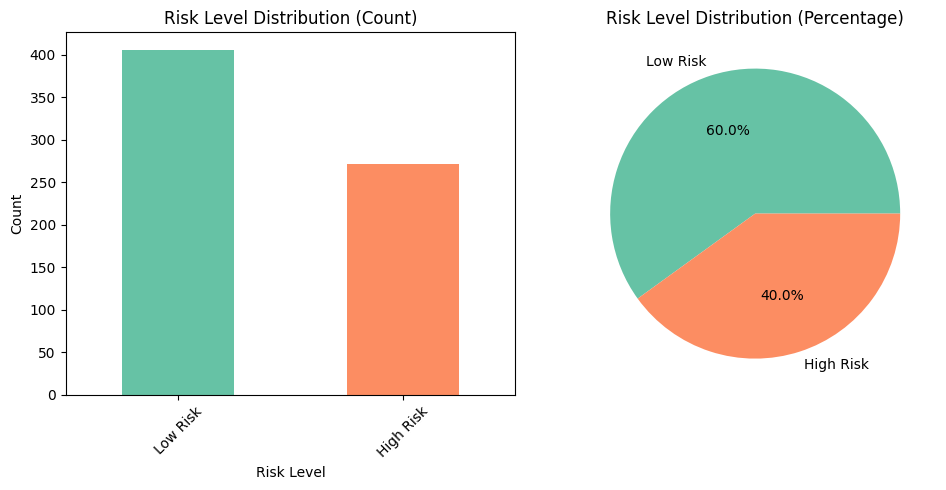

In [50]:
# Visualize target variable distribution
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
data_cleaned['RiskLevel'].value_counts().plot(kind='bar', color=plt.cm.Set2.colors)
plt.title('Risk Level Distribution (Count)')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks([0, 1], ['Low Risk', 'High Risk'], rotation=45)

plt.subplot(1, 2, 2)
data_cleaned['RiskLevel'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    labels=['Low Risk', 'High Risk'],
    colors=plt.cm.Set2.colors
    )
plt.title('Risk Level Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

## 4. Patient risk scoring - Random Forest model
### 4.1 Prepare data for modeling

In [51]:
# Define features and target variable
X = data_cleaned.drop('RiskLevel', axis=1)
y = data_cleaned['RiskLevel']
print(f"Features shape: {X.shape}, Target shape: {y.shape}")


Features shape: (677, 6), Target shape: (677,)


### 4.2 Train-Test split

In [52]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
    )

print("="*40)
print(f"Number of Training samples: {X_train.shape[0]}")
print("Class distribution:", y_train.value_counts(), sep="\n")
print("="*40)
print(f"Number of Testing samples: {X_test.shape[0]}")
print("Class distribution:", y_test.value_counts(), sep="\n")

Number of Training samples: 541
Class distribution:
RiskLevel
0    324
1    217
Name: count, dtype: int64
Number of Testing samples: 136
Class distribution:
RiskLevel
0    82
1    54
Name: count, dtype: int64


### 4.3 Train Random Forest model

In [53]:
# Build a Random Forest Model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 4.4 Generate prediction and evaluate model peformance

In [54]:
# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)
y_proba_rf = rf_classifier.predict_proba(X_test)

In [55]:
# Classification report for Random Forest model
print("="*55)
print("Random Forest Classification Report".center(55))
print("="*55)
print(classification_report(y_test, y_pred_rf, target_names=['Low Risk', 'High Risk']))
print("="*55)

# Calculate evaluation metrics
print("\nRandom Forest Overall Evaluation Metrics")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

          Random Forest Classification Report          
              precision    recall  f1-score   support

    Low Risk       0.97      0.93      0.95        82
   High Risk       0.90      0.96      0.93        54

    accuracy                           0.94       136
   macro avg       0.94      0.94      0.94       136
weighted avg       0.94      0.94      0.94       136


Random Forest Overall Evaluation Metrics
Accuracy: 0.9412
Precision: 0.9435
Recall: 0.9412
F1 Score: 0.9415


### 4.5 Confusion matrix

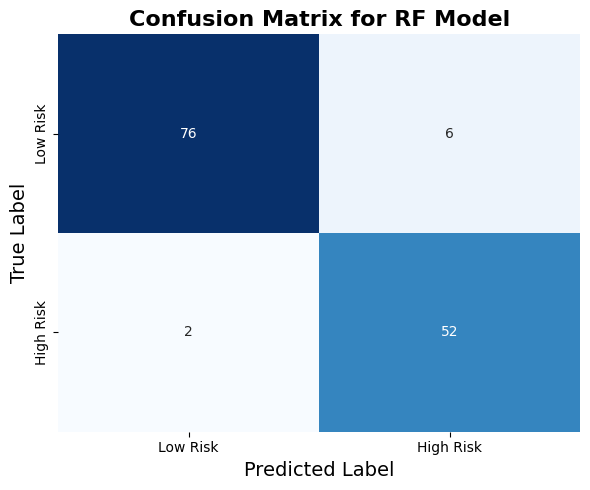

In [56]:
# Confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix for RF Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

### 4.6 ROC-AUC curve

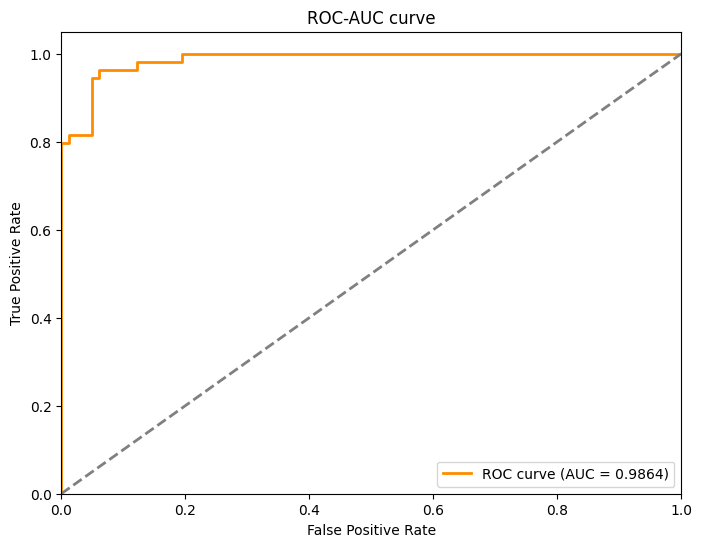

In [57]:
#  Plot ROC-AUC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba_rf[:, 1], pos_label=1)
auc_score = roc_auc_score(y_test, y_proba_rf[:, 1])
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')
plt.legend(loc='lower right')
plt.show()

### 4.7 Feature importance

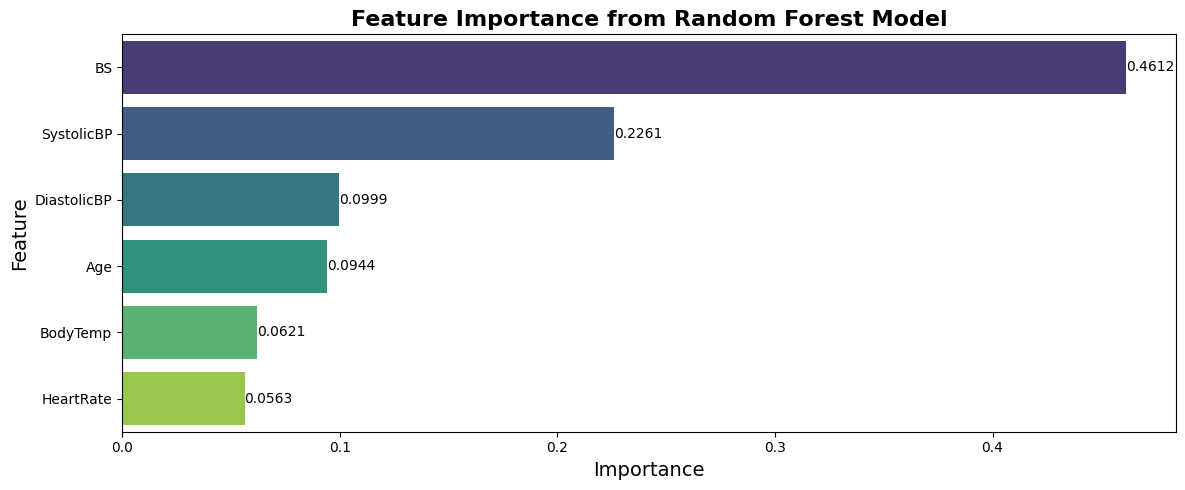

In [58]:
# Print feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f'{value:.4f}', va='center')
plt.title('Feature Importance from Random Forest Model', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

### 4.8 Save Random Forest Model

In [59]:
# Save the trained model
fr_model_filename = 'models/rf_model.joblib'

joblib.dump(rf_classifier, fr_model_filename)
print(f"RFModel saved successfully as '{fr_model_filename}'!")

# Save schema of the features
feature_schema = {'features': X.columns.tolist()}
with open('models/feature_schema.json', 'w') as f:
    json.dump(feature_schema, f)
print("Feature schema saved successfully as 'feature_schema.json'!")    

RFModel saved successfully as 'models/rf_model.joblib'!
Feature schema saved successfully as 'feature_schema.json'!


## 5. Dense neural network model
### 5.1 Scale data for neural network

In [60]:
# Data scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Statistical summary of scaled features
scaler_mean_std = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean': X_train_scaled.mean(axis=0),
    'StdDev': X_train_scaled.std(axis=0)
})
print(scaler_mean_std.head(6))

       Feature          Mean  StdDev
0          Age  4.925204e-17     1.0
1   SystolicBP  1.214884e-16     1.0
2  DiastolicBP -1.444726e-16     1.0
3           BS  2.889453e-16     1.0
4     BodyTemp  2.671102e-15     1.0
5    HeartRate -3.381973e-16     1.0


### 5.2 Build dense neural network architecture

In [ ]:
# Build a DNN model
dnn_model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
    ])

dnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                  )

dnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

### 5.3 Train neural network model

In [62]:
# train the DNN model
history = dnn_model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
    )

print("\nDNN Model Training Complete!")
print(f"Most high validation accuracy achieved: {max(history.history['val_accuracy']):.4f}")

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5671 - loss: 0.7032 - val_accuracy: 0.6055 - val_loss: 0.6810
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5949 - loss: 0.6873 - val_accuracy: 0.6422 - val_loss: 0.6528
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5903 - loss: 0.6632 - val_accuracy: 0.6422 - val_loss: 0.6273
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5995 - loss: 0.6467 - val_accuracy: 0.6514 - val_loss: 0.6047
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6319 - loss: 0.6367 - val_accuracy: 0.6881 - val_loss: 0.5840
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7153 - loss: 0.5947 - val_accuracy: 0.7431 - val_loss: 0.5634
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7083 - loss: 0.5776 - val_accuracy: 0.7798 - val_loss: 0.5421
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7431 - loss: 0.5739 - val_accuracy: 0.8073 - val_l

### 5.4 Visualize training history

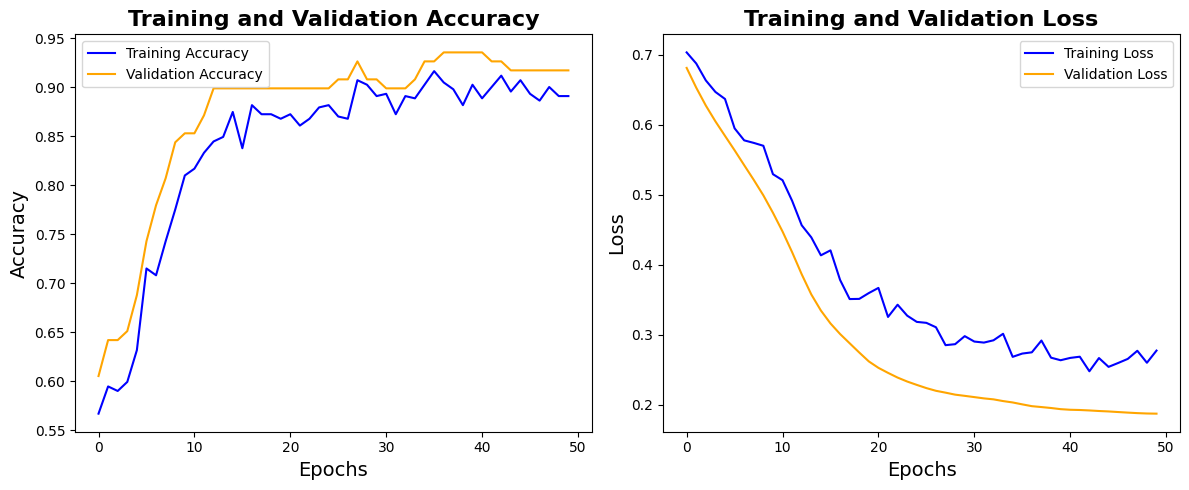

In [63]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### 5.4 Evaluate neural network model

In [64]:
# Make predictions
y_pred_proba_dnn = dnn_model.predict(X_test_scaled)
y_pred_dnn = (y_pred_proba_dnn > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [65]:
# Clsassification report for DNN model
print("="*55)
print("DNN Model Classification Report".center(55))
print("="*55)
print(classification_report(y_test, y_pred_dnn, target_names=['Low Risk', 'High Risk']))
print("="*55)

# Calculate evaluation metrics
print("\nDNN Model Overall Evaluation Metrics")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dnn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dnn, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dnn, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dnn, average='weighted'):.4f}")

            DNN Model Classification Report            
              precision    recall  f1-score   support

    Low Risk       0.93      0.91      0.92        82
   High Risk       0.87      0.89      0.88        54

    accuracy                           0.90       136
   macro avg       0.90      0.90      0.90       136
weighted avg       0.90      0.90      0.90       136


DNN Model Overall Evaluation Metrics
Accuracy: 0.9044
Precision: 0.9048
Recall: 0.9044
F1 Score: 0.9046


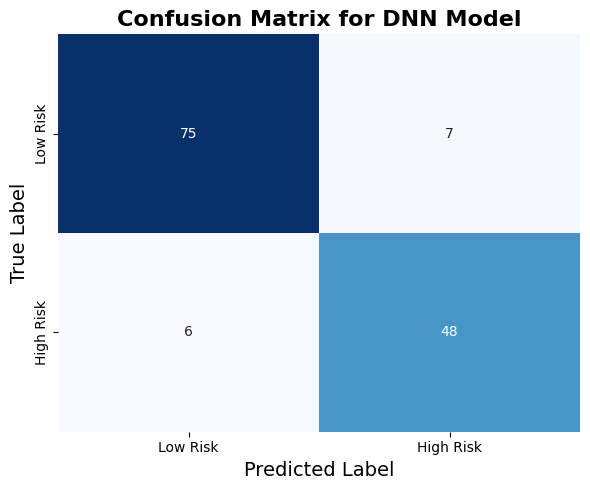

In [66]:
# Confusion matrix for DNN model
conf_matrix_dnn = confusion_matrix(y_test, y_pred_dnn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dnn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix for DNN Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

### 5.5 Save neural network model

In [67]:
# Save the DNN model
dnn_model_filename = "models/dnn_model.keras"
joblib.dump(dnn_model, dnn_model_filename)
print(f"DNN Model saved successfully as '{dnn_model_filename}'!")

DNN Model saved successfully as 'models/dnn_model.keras'!


## 6. Model comparison

In [68]:
# Compare model performances
# load the metrics to dataframe
metrics_df = pd.DataFrame({
    "Model": ["Random Forest", "DNN Model"],
    "Accuracy": [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_dnn)],
    "Precision": [precision_score(y_test, y_pred_rf, average='weighted'), precision_score(y_test, y_pred_dnn, average='weighted')],
    "Recall": [recall_score(y_test, y_pred_rf, average='weighted'), recall_score(y_test, y_pred_dnn, average='weighted')],
    "F1 Score": [f1_score(y_test, y_pred_rf, average='weighted'), f1_score(y_test, y_pred_dnn, average='weighted')]
})

# show the metrics dataframe without index
print("="*55)
print("Model Performance Comparison".center(55))
print("="*55)
print(metrics_df.to_string(index=False)) 

              Model Performance Comparison             
        Model  Accuracy  Precision   Recall  F1 Score
Random Forest  0.941176   0.943465 0.941176  0.941492
    DNN Model  0.904412   0.904803 0.904412  0.904557


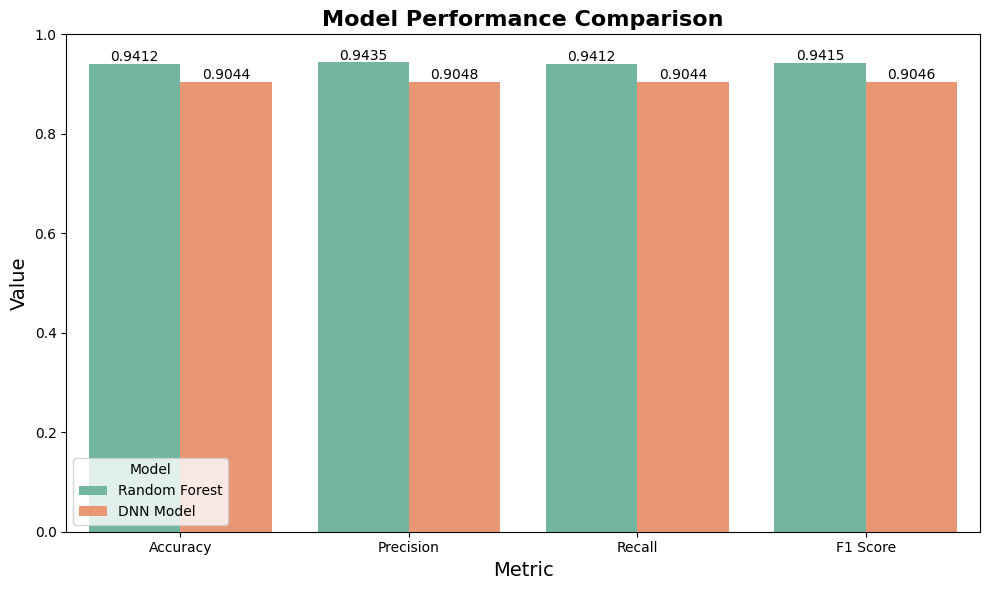

In [69]:
# Visualize model performance comparison
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted, palette='Set2')
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.ylim(0, 1)
plt.legend(title='Model')
# Add value labels on bars
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{p.get_height():.4f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.savefig(f"plots/model_performance_comparison.png")
plt.show()